In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
import keras
import tensorflow as tf
import tensorflow_probability as tfp
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
tf.random.set_seed(1)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# choose the file on your computer to upload it then


Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Sep 14 18:33:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    26W /  70W |    284MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
path = "/content/drive/MyDrive/Pedestrian_dataset/Dataset/OpenTraj/datasets/ETH/seq_eth/obsmat.txt"
csv_columns = ["frame_id", "agent_id", "pos_x", "pos_z", "pos_y", "vel_x", "vel_z", "vel_y"]
df = pd.read_csv(path, sep=r"\s+", header=None, names=csv_columns)
df

# Total Ped for : UCY_Zara01 = 148, ETH_hotel  = 432
sub_df = df[df["agent_id"]== 100]
sub_df.head()

,frame_id,agent_id,pos_x,pos_z,pos_y,vel_x,vel_z,vel_y
2156,4955.0,100.0,13.185519,0.0,6.459224,-1.254872,0.0,0.840245
2164,4961.0,100.0,12.683570,0.0,6.795322,-1.096975,0.0,0.258576
2172,4967.0,100.0,12.307938,0.0,6.666085,-0.921663,0.0,0.300877
2180,4973.0,100.0,11.946239,0.0,7.036023,-0.966555,0.0,0.642585
2187,4979.0,100.0,11.534694,0.0,7.180153,-1.184987,0.0,0.226681


In [ ]:
lookback = 8     # Looks back into 4 seconds of Past trajectory
forward_pred = 12 # Predicts 3 seconds into the future 
training_fraction = 0.85  # on the number of agents

unique_agent_ids = np.unique(df["agent_id"])
filtered_ids = []

for agent_id in unique_agent_ids:
  sub_df = df[df["agent_id"]==agent_id]
  if len(sub_df) < (lookback+forward_pred):
    continue
  else:
    filtered_ids.append(agent_id)

# random.shuffle(unique_agent_ids) # use this line to shuffle the training agent_ids
num_unique_agents = len(filtered_ids)
filtered_ids = np.array(filtered_ids)
train_agents = (filtered_ids[:int(training_fraction*num_unique_agents)])
test_agents = (filtered_ids[int(training_fraction*num_unique_agents):])


In [ ]:
sub_df = df[df["agent_id"]== 8]
sub_df.head()

,frame_id,agent_id,pos_x,pos_z,pos_y,vel_x,vel_z,vel_y
110,948.0,8.0,-2.587750,0.0,-0.415001,0.828733,0.0,1.481026
117,954.0,8.0,-2.256257,0.0,0.177410,1.142035,0.0,1.179354
124,960.0,8.0,-1.674122,0.0,0.528483,1.089783,0.0,0.685588
131,966.0,8.0,-1.384431,0.0,0.725880,1.206789,0.0,0.677196
138,972.0,8.0,-0.708691,0.0,1.070239,1.282880,0.0,0.907473


In [ ]:
def create_dataset(dataframe, agent_id_list, lookback, forward_pred):
  data_x = []
  data_y = []
  for agent_id in agent_id_list:
    sub_df = dataframe[dataframe["agent_id"]==agent_id]
    
    for j in range(len(sub_df)-lookback-forward_pred+1):
        data_x.append(sub_df.iloc[j:j+lookback, [df.columns.get_loc(c) for c in ["pos_x","pos_y","vel_x","vel_y"]]].to_numpy()) # pos_x = 3, pos_y = 5, .... (from the indices of the dataframe)
        data_y.append(sub_df.iloc[j+lookback:j+lookback+forward_pred, [df.columns.get_loc(c) for c in ["pos_x","pos_y","vel_x","vel_y"]]].to_numpy())
      # break
    # break

  return np.array(data_x), np.array(data_y)

In [ ]:
train_x, train_y = create_dataset(df, train_agents, lookback, forward_pred)
test_x, test_y = create_dataset(df, test_agents, lookback, forward_pred)

In [ ]:
print("Training Datasets:", train_x.shape, train_y.shape)
print("Test Datasets:", test_x.shape, test_y.shape)

Training Datasets: (2195, 8, 4) (2195, 12, 4)
Test Datasets: (419, 8, 4) (419, 12, 4)


In [ ]:
# Normalize the data:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
train_y = scaler.transform(train_y.reshape(-1, train_y.shape[-1])).reshape(train_y.shape)
test_x = scaler.transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)
test_y = scaler.transform(test_y.reshape(-1, test_y.shape[-1])).reshape(test_y.shape)


In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from keras import backend as K
# from keras import optimizers
from keras.callbacks import TerminateOnNaN
from keras.layers import Dropout
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from keras.optimizers import Adam

# latent_dim = 128

# # Define an input sequence and process it.
# encoder_inputs = Input(shape=(lookback, train_x.shape[2]))
# encoder = LSTM(latent_dim, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# # We discard `encoder_outputs` and only keep the states.
# encoder_states = [state_h, state_c]

# # Set up the decoder, using `encoder_states` as initial state.
# decoder_inputs = Input(shape=(None, latent_dim))
# # We set up our decoder to return full output sequences,
# # and to return internal states as well. We don't use the 
# # return states in the training model, but we will use them in inference.
# decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
#                                      initial_state=encoder_states)
# decoder_dense = Dense(train_y.shape[2], activation='linear')
# decoder_outputs = decoder_dense(decoder_outputs)

# # Define the model that will turn
# # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
# model = Model([encoder_inputs, decoder_inputs], decoder_outputs)





def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


input_sequence = Input(shape=(lookback, train_x.shape[2]))
print(input_sequence)
encoder = LSTM(128, activation='tanh',return_sequences=True, dropout = 0.1)(input_sequence, training = True)
encoder = LSTM(64, activation='tanh', return_sequences=False, dropout = 0.3)(encoder)
r_vec = RepeatVector(forward_pred)(encoder)
decoder = LSTM(128, return_sequences=True, activation = 'tanh', dropout=0.3)(r_vec) # maybe use dropout=0.1
output = TimeDistributed(Dense(train_y.shape[2], activation='linear'))(decoder)


# optimiser = optimizers.Adam(clipnorm=1)

enc_dec_model = Model(input_sequence, output)
enc_dec_model.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=['mean_squared_error'])
enc_dec_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 4)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 8, 128)            68096     
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 12, 64)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 12, 128)           98816     
                                             

In [ ]:
checkpoint_filepath = 'path_to_checkpoint_filepath'
checkpoint_callback = ModelCheckpoint(
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor='val_loss',
 mode='min',
 save_best_only=True)
early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.002,
 patience=10,
 mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='loss', factor=0.2, mode='min', patience=3, min_lr=0.002)

In [ ]:
# patience_val = 100
# early_stopping = EarlyStopping(
#                             monitor = 'val_main_output_loss', 
#                             patience = patience_val, 
#                             verbose=1)

epochs = 50
batch_size = 32
validation = 0.1
# callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback]
history = enc_dec_model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation, callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/50
60/62 [============================>.] - ETA: 0s - loss: 0.0401 - mean_squared_error: 0.0401

62/62 [==============================] - 18s 223ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - lr: 0.0010
Epoch 2/50
57/62 [==========================>...] - ETA: 0s - loss: 0.0170 - mean_squared_error: 0.0170

62/62 [==============================] - 12s 202ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.0146 - mean_squared_error: 0.0146

62/62 [==============================] - 14s 223ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - lr: 0.0010
Epoch 4/50
56/62 [==========================>...] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.0131

62/62 [==============================] - 13s 221ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 1s 9ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115

62/62 [==============================] - 13s 205ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 1s 9ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - lr: 0.0010
Epoch 8/50
62/62 [==============================] - 1s 9ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - lr: 0.0010
Epoch 9/50
62/62 [==============================] - ETA: 0s - loss: 0.0106 - mean_squared_error: 0.0106

62/62 [==============================] - 13s 206ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - lr: 0.0010
Epoch 10/50
62/62 [==============================] - 1s 9ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - lr: 0.0010
Epoch 11/50
62/62 [==============================] - 1s 9ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - lr: 0.0010
Epoch 12/50
61/62 [============================>.] - ETA: 0s - loss: 0.0098 - mean_squared_error: 0.0098

62/62 [==============================] - 13s 208ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - lr: 0.0010
Epoch 13/50
62/62 [==============================] - 1s 10ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - lr: 0.0010
Epoch 14/50
62/62 [==============================] - 1s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - lr: 0.0010


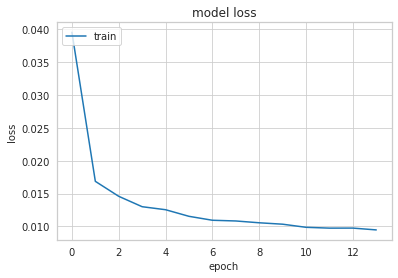

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(test_y)

[[[-0.14037665 -0.31836351  0.47546125  0.14817728]
  [-0.09386833 -0.29026447  0.46992793  0.1453057 ]
  [-0.04857663 -0.27384609  0.48631711  0.10758847]
  ...
  [ 0.32069433 -0.1716532   0.56758692 -0.01121756]
  [ 0.37844929 -0.16268561  0.55968362 -0.0128318 ]
  [ 0.43099217 -0.1537193   0.56991244 -0.07767542]]

 [[-0.09386833 -0.29026447  0.46992793  0.1453057 ]
  [-0.04857663 -0.27384609  0.48631711  0.10758847]
  [ 0.00130936 -0.25208746  0.43433057  0.10613673]
  ...
  [ 0.37844929 -0.16268561  0.55968362 -0.0128318 ]
  [ 0.43099217 -0.1537193   0.56991244 -0.07767542]
  [ 0.4908552  -0.15565218  0.56024631 -0.14072288]]

 [[-0.04857663 -0.27384609  0.48631711  0.10758847]
  [ 0.00130936 -0.25208746  0.43433057  0.10613673]
  [ 0.03588711 -0.23591311  0.47463924  0.10184584]
  ...
  [ 0.43099217 -0.1537193   0.56991244 -0.07767542]
  [ 0.4908552  -0.15565218  0.56024631 -0.14072288]
  [ 0.54140598 -0.15728438  0.5335652  -0.07810474]]

 ...

 [[ 0.1813709   0.22853063  0.6789

In [ ]:
# test_x = tf.stack(test_x)
# test_y = tf.stack(test_y)
score = enc_dec_model.evaluate(test_x, np.squeeze(test_y), verbose=2)
print(score[0])

14/14 - 0s - loss: 0.0102 - mean_squared_error: 0.0102 - 63ms/epoch - 5ms/step
0.01020087394863367


In [ ]:
test_pred = enc_dec_model.predict(test_x)
train_pred = enc_dec_model.predict(train_x)
print(test_pred.shape)

# test_pred = scaler.inverse_transform(test_pred.reshape(-1, test_pred.shape[-1])).reshape(test_pred.shape)
# train_pred = scaler.inverse_transform(train_pred.reshape(-1, train_pred.shape[-1])).reshape(train_pred.shape)

(419, 12, 4)


## Monte Carlo Dropout

In [ ]:
def predict_dropout(model, x, samples=100):
    '''
    Args:
        model: The trained keras model
        x: the input tensor with shape [N, M]
        samples: the number of monte carlo samples to collect
    Returns:
        y_mean: The expected value of our prediction
        y_std: The standard deviation of our prediction
    '''
    mu_arr = []
    si_arr = []
    y_pred_do = []

    for t in range(samples):
        y_pred = model(x, training=True)
        y_pred_do.append(y_pred)

    y_pred_do = np.array(y_pred_do)


    return y_pred_do 

In [ ]:
samples = 30
yhat_do = predict_dropout(enc_dec_model, test_x, samples)
yhat_do = np.array(yhat_do)
# yhat_do = scaler.inverse_transform(yhat_do.reshape(-1, yhat_do.shape[-1])).reshape(yhat_do.shape)



In [ ]:
test_pred = scaler.inverse_transform(test_pred.reshape(-1, test_pred.shape[-1])).reshape(test_pred.shape)
train_pred = scaler.inverse_transform(train_pred.reshape(-1, train_pred.shape[-1])).reshape(train_pred.shape)

In [ ]:
test_x = scaler.inverse_transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)
test_y = scaler.inverse_transform(test_y.reshape(-1, test_y.shape[-1])).reshape(test_y.shape)
train_x = scaler.inverse_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
train_y = scaler.inverse_transform(train_y.reshape(-1, train_y.shape[-1])).reshape(train_y.shape)
yhat_do = scaler.inverse_transform(yhat_do.reshape(-1, yhat_do.shape[-1])).reshape(yhat_do.shape)

In [ ]:
dropout_rate = 0.3
decay = 1e-6
N = train_x.shape[0]
l2 = 0.01

mu =  np.mean(yhat_do, axis=0)
var = np.var(yhat_do, axis=0)
tau = l2 * (1.- dropout_rate)/(2. * N * decay)
var += (1./ tau)
sigma = np.sqrt(var) 
print(sigma)

[[[0.9304209  0.87434375 0.8110362  0.79291743]
  [0.9171918  0.9012839  0.8072707  0.79316795]
  [0.91588527 0.907593   0.79762435 0.79295814]
  ...
  [0.8654605  0.8414202  0.79380345 0.7929347 ]
  [0.8641326  0.84149307 0.7942928  0.7928182 ]
  [0.84737706 0.84550244 0.7939969  0.7933103 ]]

 [[0.96403563 0.87449217 0.8132973  0.79344803]
  [0.97946495 0.86395895 0.80270374 0.79314077]
  [1.0309535  0.8940793  0.79988456 0.79318213]
  ...
  [0.9287074  0.8206854  0.7941659  0.79285467]
  [0.9250971  0.823429   0.7944754  0.79277587]
  [0.9307338  0.8197214  0.79404706 0.79282194]]

 [[0.926674   0.91253746 0.81313986 0.7932747 ]
  [0.90080214 0.8945969  0.8008736  0.79293066]
  [0.94211483 0.8720062  0.7977775  0.7925937 ]
  ...
  [0.91380167 0.83206046 0.79316676 0.79244095]
  [0.9189364  0.82520765 0.79285276 0.79264104]
  [0.92242104 0.83085996 0.79340476 0.79264206]]

 ...

 [[0.94947034 0.849916   0.8230284  0.7933357 ]
  [0.98374134 0.8429351  0.8078181  0.79287064]
  [1.01775

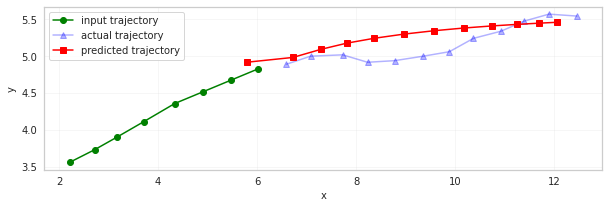

[2.2108062 2.7147921 3.1637242 3.7052366 4.3350193 4.9023752 5.4608811
 6.0107425] [3.5606291 3.7314972 3.901001  4.1102166 4.3573903 4.5153724 4.6708901
 4.8240008]


In [ ]:


def plot_trajectory(x_true, y_true, y_pred,  id=0):
  plt.figure(figsize=(10,3))
  plt.plot(x_true[id,:,0], x_true[id,:,1], color='g', label="input trajectory", marker='o')
  plt.plot(y_true[id,:,0], y_true[id,:,1], color='b', label="actual trajectory", alpha=0.3, marker='^')
  plt.plot(y_pred[id,:,0], y_pred[id,:,1], color='r', label="predicted trajectory", marker='s')
  plt.legend(loc="best")
  plt.xlabel('x')
  plt.ylabel('y')
  # plt.xlim([-1,-3])
  plt.grid("on", alpha=0.2)
  plt.show()
  print(x_true[id,:,0], x_true[id,:,1])

# plot_trajectory(test_x, test_y, test_pred, id = 150)
plot_trajectory(test_x, np.squeeze(test_y), np.squeeze(test_pred), id = 20)


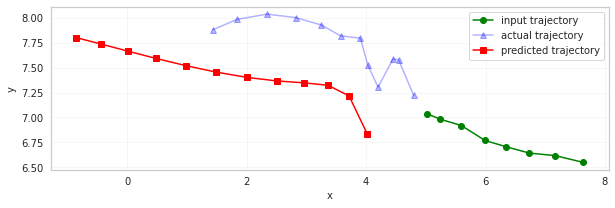

[7.6353672 7.1670909 6.7341728 6.3426199 5.9914678 5.5973695 5.2394674
 5.0151027] [6.5483408 6.616482  6.6414608 6.7058853 6.7683596 6.9181861 6.9822277
 7.0384316]


In [ ]:
plot_trajectory(train_x, train_y, train_pred, id=10)

In [ ]:
test_pred = np.squeeze(test_pred)
test_y = np.squeeze(test_y)

test_pred = test_pred[None,:]
test_y = test_y[None,:]


In [ ]:
# def rmse(yhat_d)
yhat_do_mean = yhat_do.mean(axis=0)[:,:,0:2]
yhat_do_std = yhat_do.std(axis=0)[:,:,0:2]
test_y_squeeze = test_y.squeeze(0)[:,:,0:2]
print(yhat_do_std.shape)
print(test_y_squeeze.shape)

rmse = np.sqrt(((yhat_do_mean - test_y_squeeze)**2).sum(axis=2)).mean(axis=1)
print(rmse[2])

(419, 12, 2)
(419, 12, 2)
0.5961794197916169


In [ ]:
FDE_pred = np.sqrt(((yhat_do_mean - test_y_squeeze)**2).sum(axis=2))[:,-1]
ADE_pred = np.sqrt(((yhat_do_mean - test_y_squeeze)**2).sum(axis=2)).mean(axis=1)

print(FDE_pred[100],ADE_pred[0])


0.10366425718193223 0.7225743563476209


In [ ]:

# Evaluate the prediction metrics : ADE, FDE
# ADE : Average Displacement Error , FDE : Final Displacement Error


def average_displacement_error(forward_pred, y_pred, y_true, id=0 ):

  final_ADE = np.zeros(y_pred.shape[0])
  for N in range(y_pred.shape[0]):
    ADE = 0.0 # Initialize ADE for each trajectory as 0
    for n in range(forward_pred):
      ADE += np.sqrt((y_pred[N,id,n,0] - y_true[0,id,n,0])**2 + (y_pred[N,id,n,1] - y_true[0,id,n,1])**2)
    ADE = ADE/forward_pred 
  
    final_ADE[N] = ADE
  
  print(final_ADE)
  mean, var = np.mean(final_ADE, axis = 0), np.std(final_ADE, axis = 0)
  return mean, var


def final_displacement_error(forward_pred, y_pred, y_true, id=0):

  final_FDE = np.zeros(y_pred.shape[0])
  for N in range(y_pred.shape[0]):
    FDE = np.sqrt((y_pred[N,id,-1,0] - y_true[0,id,-1,0])**2 + (y_pred[N,id,-1,1] - y_true[0,id,-1,1])**2)
    final_FDE[N] = FDE

  
  mean, var = np.mean(final_FDE, axis = 0), np.std(final_FDE, axis = 0)
  return mean, var


id_no = 10
[ADE_do_mean, ADE_do_std ] = average_displacement_error(forward_pred, yhat_do, test_y, id_no )
[ADE_LSTM_mean, ADE_LSTM_std] = average_displacement_error(forward_pred, test_pred, test_y, id_no )

[FDE_do_mean, FDE_do_std] = final_displacement_error(forward_pred, yhat_do, test_y, id_no)
[FDE_LSTM_mean, FDE_LSTM_std] = final_displacement_error(forward_pred, test_pred, test_y, id_no)



print(ADE_do_mean, ADE_do_std)
print(ADE_LSTM_mean, ADE_LSTM_std)

print(FDE_do_mean, FDE_do_std)
print(FDE_LSTM_mean, FDE_LSTM_std)

[0.77896253 1.14659529 1.02524662 0.84605851 0.48350923 0.88320972
 1.21812649 1.56871491 0.76496894 0.66246011 1.14706663 1.31885977
 0.85764102 0.81950363 2.08435473 0.73685071 0.92370188 0.90837915
 1.24830911 1.50285238 1.82764298 0.54752976 0.72861445 1.00278257
 0.75747283 1.0725598  0.78133462 1.14441471 0.6400752  1.53735612]
[0.96214678]
1.0321718134613882 0.3718694794881764
0.9621467807034336 0.0
1.1723641089832746 0.39779326344662685
1.1358082483078695 0.0


In [ ]:
def get_results(yhat_do, test_y):
  #yhat_do shape: n_samples, id_samples, forward_pred, features
  #test_y shape: 1, id_samples, forward_pred, features
  yhat_do_mean = yhat_do.mean(axis=0)[:,:,0:2] # 337, 12, 2 (mu_x, mu_y for every id, time_pred)
  yhat_do_std = yhat_do.std(axis=0)[:,:,0:2] # 337, 12, 2
  
  ADE_pred = np.sqrt(((yhat_do_mean - test_y_squeeze)**2).sum(axis=2)).mean(axis=1) # RMSE_mean_pred has shape(id_samples,)
  FDE_pred = np.sqrt(((yhat_do_mean - test_y_squeeze)**2).sum(axis=2))[:,-1] # Finite Displacement error(id_samples,)


  cov_mat = np.zeros((yhat_do.shape[1], yhat_do.shape[2], 2, 2))
  for i in range(yhat_do.shape[1]): # id_samples
    for j in range(yhat_do.shape[2]): # forward_pred
      cov_mat[i, j, :, :] = np.cov(yhat_do[:,i,j,0], yhat_do[:,i,j,1])

  return yhat_do_mean, yhat_do_std, ADE_pred, FDE_pred,cov_mat
yhat_do_mean, yhat_do_std, ADE_pred_per_sample, FDE_pred_per_sample, cov_mat = get_results(yhat_do, test_y)
LSTM_mean, LSTM_std, ADE_per_sample_LSTM, FDE_per_sample_LSTM, cov_mat_LSTM = get_results(test_pred, test_y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: Degrees of freedom <= 0 for slice
  
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [ ]:

ADE_per_sample_LSTM.shape

(419,)

In [ ]:

# ADE and FDE over samples
ADE_per_sample = ADE_pred_per_sample[id_no]
ADE_std_x = yhat_do_std[id_no,:,0]
ADE_std_y = yhat_do_std[id_no,:,1]

FDE_per_sample = FDE_pred_per_sample[id_no]
FDE_std_x = yhat_do_std[id_no,-1,0]
FDE_std_y = yhat_do_std[id_no,-1,1]


ADE_final_MCD = np.mean(ADE_pred_per_sample)
FDE_final_MCD = np.mean(FDE_pred_per_sample)

ADE_final_LSTM = np.mean(ADE_per_sample_LSTM)
FDE_final_LSTM = np.mean(FDE_per_sample_LSTM)

print(ADE_per_sample_LSTM[id_no],FDE_per_sample_LSTM[id_no],ADE_final_LSTM,FDE_final_LSTM)
print(ADE_per_sample,FDE_per_sample,ADE_final_MCD,FDE_final_MCD)



0.9621467807034337 1.1358082483078695 0.7781435882004843 1.1186986687926437
0.8301192122185926 1.0617762816121092 0.6087718464534517 0.9799762173029872


In [ ]:

print(yhat_do_std[150,6,0])
print(yhat_do_std[150,6,1])


0.31704557
0.18795852


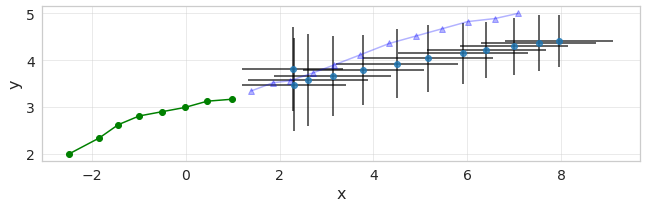

In [ ]:
def plot_trajectory(x_true, y_true, y_pred, y_pred_do, samples, id=0, title = 'Pedestrian_traj_do_0.2_ and FP = %i'):
  plt.figure(figsize=(10,3),  tight_layout=True)
  plt.rcParams.update({'font.size': 10})
  plt.rcParams["axes.edgecolor"] = "black"
  plt.rcParams["axes.linewidth"]  = 1.25
  sns.set_style("whitegrid")
  plt.plot(x_true[id,:,0], x_true[id,:,1], color='g', label="input trajectory", marker='o')
  plt.plot(y_true[id,:,0], y_true[id,:,1], color='b', label="Ground Truth", alpha=0.3, marker='^')
  # plt.plot(y_pred[id,:,0], y_pred[id,:,1], color='r', label="LSTM", marker='s', alpha = 0.5)
  yhat_do_mean = y_pred_do.mean(axis=0)[:,:,0:2]
  yhat_do_std = y_pred_do.std(axis=0)[:,:,0:2]
  
  l, caps, c = plt.errorbar(yhat_do_mean[id,:,0], yhat_do_mean[id,:,1], xerr= 2* yhat_do_std[id,:,0], yerr= 2* yhat_do_std[id,:,1], fmt='o', ecolor='k', 
                            capthick=2, alpha = 0.8, label='$\mu$, $2\sigma_{x}$, $2\sigma_{y}$')
 
    
  # plt.plot(yhat_do_mean[id,:,0], yhat_do_mean[id,:,1], color='r',marker='s',alpha = 0.4,label='LSTM + MC Dropout')
  # plt.xlim([-1,-0.5])
  # plt.ylim([1,5])
  # plt.plot(mu[id,:,0], mu[id,:,1], 'm-', label='LSTM + MC Dropout', marker = 'd')
  # plt.fill_between(mu[id,:,0], mu[id,:,1] - sigma[id,:,1], mu[id,:,1] + sigma[id,:,1], color='b', alpha=0.2)
  # for t in range(samples-1):
  #   plt.plot(y_pred_do[t,id,:,0], y_pred_do[t,id,:,1], color='c', alpha = 0.075)
  # plt.plot(y_pred_do[-1,id,:,0], y_pred_do[-1,id,:,1], color='c', alpha = 0.075,label = 'LSTM + MC')
  # plt.errorbar(mu[id,:,0], mu[id,:,1], xerr=sigma[id,:,0], fmt='.')
  # lower_bound = np.array(mu[id,:,1]) - np.array(sigma[id,:,1])
  # upper_bound =  np.array(mu[id,:,1]) + np.array(sigma[id,:,1])
  # plt.fill_between(mu[id,:,1], lower_bound, upper_bound, facecolor='lightblue')

  
  # x_hat_upper = yhat_do_mean[id,:,0]+yhat_do_std[id,:,0]*0.672
  # x_hat_lower = yhat_do_mean[id,:,0] - yhat_do_std[id,:,0]*0.672
  # x_hat_2upper = yhat_do_mean[id,:,0]+ yhat_do_std[id,:,0]*0.95
  # x_hat_2lower = yhat_do_mean[id,:,0]-yhat_do_std[id,:,0]*0.95
 
  # # # Fill between plot:

  # plt.fill_betweenx(yhat_do_mean[id,:,1],
  #                   x_hat_upper, 
  #                   x_hat_lower, 
  #                   alpha=0.43, color='C0')
  # plt.fill_betweenx(yhat_do_mean[id,:,1],
  #                   x_hat_2upper, 
  #                   x_hat_2lower, 
  #                   alpha=0.23, color='C0', label='Uncertainty')


  # plt.legend(loc="lower right", fontsize = 12)
  plt.xlabel('x', fontsize=16)
  plt.ylabel('y',fontsize=16)
  # plt.yticks(np.arange(1,5.1,2))
  plt.grid("on", alpha=0.5)
  plt.tick_params(axis='both', which='major', labelsize=14)
 
  plt.gca().set_aspect('equal', adjustable='box')

  # saving the figure:
  from google.colab import files
  filename1 = title + ".png"
  filename2 = title + ".pdf"
  plt.title("")
  plt.savefig(filename1,dpi=300)
  plt.savefig(filename2, format='pdf')
  plt.tight_layout()
  plt.show()

plot_trajectory(test_x, np.squeeze(test_y), np.squeeze(test_pred), yhat_do, samples, id_no , title = 'LSTM_traj_do_0.2_ andFP_4.8 secs_ID_58_traj')



In [ ]:
# Estimating the 95% Confidence interval:
def conf_int( y_true, y_pred, y_pred_do, forward_pred,id):

  yhat_do_mean = y_pred_do.mean(axis=0)[:,:,0:2]
  yhat_do_std = y_pred_do.std(axis=0)[:,:,0:2]

  cnt_tot_x = []
  cnt_tot_y = []

  for id in range(y_true.shape[0]): 

    y_hat_2upper = yhat_do_mean[id,:,1]+ 2*yhat_do_std[id,:,1]
    y_hat_2lower = yhat_do_mean[id,:,1] - 2*yhat_do_std[id,:,1]
    x_hat_2upper = yhat_do_mean[id,:,0]+ 2* yhat_do_std[id,:,0]
    x_hat_2lower = yhat_do_mean[id,:,0]- 2* yhat_do_std[id,:,0]


    cnt_x_per_sample = []
    cnt_y_per_sample = []
    for t in range (forward_pred):

      cnt_x = 0
      cnt_y = 0

      
      CI_x_up = (y_true[id,t,0] - x_hat_2upper[t])
      CI_x_low = (y_true[id,t,0] - x_hat_2lower[t])
      CI_y_up = (y_true[id,t,1] - y_hat_2upper[t])
      CI_y_low = (y_true[id,t,1] - y_hat_2lower[t])


      if ( (CI_x_up <0 and  CI_x_low >0 ) or (CI_x_up >0 and  CI_x_low <0 )):
        cnt_x += 1
      if ((CI_y_up <0 and  CI_y_low >0 ) or (CI_y_up >0 and  CI_y_low <0 )):
        cnt_y += 1
      
      cnt_x_per_sample.append(cnt_x)
      cnt_y_per_sample.append(cnt_y)

    cnt_tot_x.append(np.sum(cnt_x_per_sample)*100/forward_pred)
    cnt_tot_y.append(np.sum(cnt_y_per_sample)*100/forward_pred)
  
  return np.array((cnt_tot_x)),np.array((cnt_tot_y))

cnt_x, cnt_y = conf_int( np.squeeze(test_y), np.squeeze(test_pred), yhat_do, forward_pred, id_no)

In [ ]:
print(np.mean(cnt_x), np.std(cnt_x))
print(np.mean(cnt_y), np.std(cnt_y))

75.28325123152709 30.291275878635453
82.59852216748769 26.348884082581026


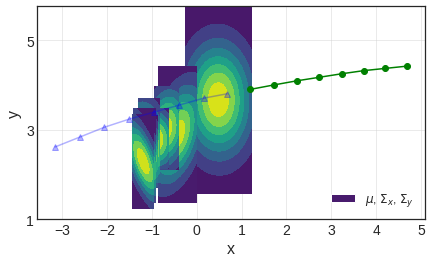

In [ ]:

# Importing the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal


plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']= 6,4
fig = plt.figure()

# Initializing the random seed
# random_seed=1000

# List containing the variance
# covariance values
# cov_val = [-0.8, 0, 0.8]

# For a specific ID:
id_no = 58

for pred in range(forward_pred):
  # Setting mean of the distributino
  # to be at (0,0)
  mean = yhat_do_mean[id_no,pred,:]

  # Storing density function values for
  # further analysis
  pdf_list = []




  # Initializing the covariance matrix
  cov = (cov_mat[id_no, pred,:])

  # print(mean.shape, cov.shape)
  # Generating a Gaussian bivariate distribution
  # with given mean and covariance matrix
  distr = multivariate_normal(cov = cov, mean = mean,
                seed = tf.random.set_seed(1))

  # Generating a meshgrid complacent with
  # the 3-sigma boundary
  mean_1, mean_2 = mean[0], mean[1]
  sigma_1, sigma_2 = cov[0,0], cov[1,1]

  x = np.linspace(mean_1-3*sigma_1, mean_1+3*sigma_1, num=100)
  y = np.linspace(mean_2-3*sigma_2, mean_2+3*sigma_2, num=100)
  X, Y = np.meshgrid(x,y)
  
  # Generating the density function
  # for each point in the meshgrid
  pdf = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

  # Plotting the density function values
  key = 131
  # ax = fig.add_subplot(key, projection = '3d')
  # ax.plot_surface(X, Y, pdf, cmap = 'viridis')
  # plt.xlabel("x1")
  # plt.ylabel("x2")
  # plt.title(f'Covariance between x1 and x2 = {val}')
  pdf_list.append(pdf)
  # ax.axes.zaxis.set_ticks([])

  # plt.tight_layout()
  # plt.show()


# Plotting contour plots
  for idx, val in enumerate(pdf_list):
    cntr = plt.contourf(X, Y, val, cmap='viridis')
  # cbar = fig.colorbar(cntr)
  # plt.colorbar()

  proxy = [plt.Rectangle((0,0),1,0,fc = pc.get_facecolor()[0]) 
    for pc in cntr.collections]
  legend1 = plt.legend(proxy,["$\mu$, $\Sigma_{x}$, $\Sigma_{y}$"], loc = "lower right", fontsize =12 )

yhat_do_mean = yhat_do.mean(axis=0)[:,:,0:2]

plt.plot(test_x[id_no,:,0], test_x[id_no,:,1], color='g', label="input trajectory", marker='o')
plt.plot(np.squeeze(test_y)[id_no,:,0], np.squeeze(test_y)[id_no,:,1], color='b', label="Ground Truth", alpha=0.3, marker='^')
# plt.plot(yhat_do_mean[id_no,:,0], yhat_do_mean[id_no,:,1], color='r', label="1D-CNN", marker='s', alpha = 0.5)
plt.xlabel("x1")
plt.ylabel("x2")
# plt.title(f'Covariance between x1 and x2 ')
# plt.ylim([1,5])
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()

plt.xlabel('x', fontsize=16)
plt.ylabel('y',fontsize=16)
plt.yticks(np.arange(1,5.1,2))
# legend2 = plt.legend(loc=4, fontsize = 12)
plt.grid("on", alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=14)
filename = "LSTM_Bivariate_Normal_Distribution_uncertainty_states"
filename1 = filename + ".png"
filename2 = filename + ".pdf"
plt.title("")
plt.savefig(filename1,dpi=300)
plt.savefig(filename2, format='pdf')
plt.show()


In [ ]:
plt.figure(figsize=(6, 5))
plt.rcParams.update({'font.size': 14})
# sns.distplot(cov_mat[:,:,0,0], stat='density', ax=ax[0], color='b')
sns.distplot(np.sqrt(cov_mat[:,:,0,0]), color='b',hist = False, label = 'cov_x')
sns.distplot(np.sqrt(cov_mat[:,:,1,1]), color='r',hist = False, label = 'cov_y')
sns.distplot(np.sqrt(cov_mat[:,:,0,1]), color='g',hist = False, label = 'cov_xy')
plt.xlabel("Standard Deviation ", fontsize=15)
plt.ylabel("Density ", fontsize=15)
plt.grid("on", alpha=0.5)
# plt.xlim([-0.2,0.5])
plt.tight_layout()
plt.legend()

title = 'covariance matrix distribution_LSTM'
filename1 = title + ".png"
filename2 = title + ".pdf"
plt.savefig(filename1,dpi=300)
plt.savefig(filename2, format='pdf')
plt.show()



NameError: ignored

In [ ]:
ADE = 0.0 # Initialize ADE for each trajectory as 0
for n in range(forward_pred):
  ADE += np.sqrt((yhat_do[:,:,n,0] - test_y[0,:,n,0])**2 + (yhat_do[:,:,n,1] - test_y[0,:,n,1])**2)
ADE = ADE/forward_pred 

print(ADE.shape)

(30, 862)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


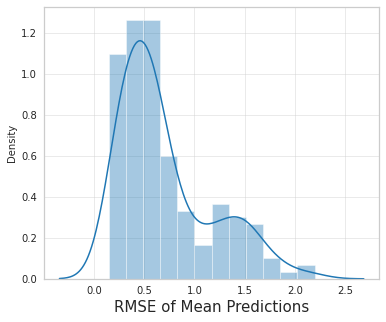

In [ ]:
plt.figure(figsize=(6, 5))
sns.distplot(ADE_pred_per_sample, kde=True)
plt.xlabel("RMSE of Mean Predictions", fontsize=15)
plt.grid("on", alpha=0.5)
plt.show()